In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/P3DCV/Diff-FMAPs/code/"
import sys
sys.path.insert(0, "/content/drive/MyDrive/P3DCV/Diff-FMAPs/code/")

/content/drive/MyDrive/P3DCV/Diff-FMAPs/code


In [ ]:
!pip install joblib
!pip install plyfile
!pip install polyscope
!pip install scikit-learn
!pip install scipy
!pip install threadpoolctl
!pip install tqdm
!pip install typing-extensions
!pip install libigl
!pip install potpourri3d
!pip install robust_laplacian

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.3/869.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.1/390.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
import igl
import numpy as np
import os
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
from Diffusionnet_MPIFAUST_dataset import DiffusionnetFaustDataset
from model_diffusionnet import FunctionalMapCorrespondenceWithDiffusionNetFeatures

from tqdm import tqdm

import torch
import matplotlib.pyplot as plt


In [ ]:
dtype = torch.float32
# model
input_features = 'xyz' # one of ['xyz', 'hks']
k_eig = 128

# functional maps settings
n_fmap = 30 # number of eigenvectors used within functional maps
n_feat = 20 # dimension of features computed by DiffusionNet extractor
lambda_param = 1e-3 # functional map block regularization parameter

# training settings
train = True
n_epoch = 50
lr = 5e-4
decay_every = 9999
decay_rate = 0.1
augment_random_rotate = (input_features == 'xyz')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epoch = 100
lr = 5e-4
decay_every = 9999
decay_rate = 0.1
root_dir = "/content/drive/MyDrive/P3DCV/data/"
op_cache_dir = os.path.join(root_dir, "op_cache")
#defining train and test set
train_set = DiffusionnetFaustDataset(root_dir, name="MPI-FAUST", train=True, k_eig=k_eig, use_cache=True, op_cache_dir=op_cache_dir)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_set = DiffusionnetFaustDataset(root_dir, name="MPI-FAUST", train=False, k_eig=k_eig, use_cache=True, op_cache_dir=op_cache_dir)
test_loader = DataLoader(test_set, batch_size=2, shuffle=True)
'''
IMPORTANT: Model Saving
'''
model_save_dir = os.path.join(root_dir, "models", "diffusionet")
if not os.path.exists(model_save_dir):
  os.makedirs(model_save_dir, exist_ok=True)

length of dataset: 6320
using dataset cache path: /content/drive/MyDrive/P3DCV/data/MPI-FAUST/cache/train.pt
  --> loading dataset from cache
length of dataset: 190
using dataset cache path: /content/drive/MyDrive/P3DCV/data/MPI-FAUST/cache/test.pt
  --> loading dataset from cache


In [ ]:
for i, data in enumerate(test_loader):
  shape1, shape2 = data

  verts1, faces1, frames1, mass1, L1, evals1, evecs1, gradX1, gradY1, hks1 = shape1[:10]
  verts2, faces2, frames2, mass2, L2, evals2, evecs2, gradX2, gradY2, hks2 = shape2[:10]
  print("verts1 shape", verts1.dtype)
  print("verts2 shape", verts2.dtype)
  print("mass1 shape", mass1.dtype)
  print("evecs1 shape", evecs1.dtype)
  print("gradX1 shape", gradX1.dtype)
  print("gradY1 shape", gradY1.dtype)
  print("hks1 shape", hks1.dtype)


In [ ]:
model = FunctionalMapCorrespondenceWithDiffusionNetFeatures(
                        n_feat=n_feat,
                        input_features=input_features,
                        lambda_param=lambda_param
                        )


model = model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)

In [ ]:
# Training Loop
epoch_train_loss = []
epoch_val_loss = []
for epoch in range(n_epoch):
    train_losses = []
    val_losses = []
    faust_losses = []
    metrics = []
    # Training single Epoch
    model.train()
    for i, data in enumerate(train_loader):
        shapeA, shapeB = data
        *shapeA, nameA = shapeA
        *shapeB, nameB = shapeB
        shapeA, shapeB = [x.to(device) for x in shapeA], [x.to(device) for x in shapeB]
        optim.zero_grad()

        # Obtaining predicted basis
        basisA, basisB = model(shapeA, shapeB)#cat_pred.shape (B, n_points, k)

        # Computing optimal transformation
        pseudo_inv_A = torch.pinverse(basisA)
        C_opt = torch.matmul(pseudo_inv_A, basisB)
        opt_A = torch.matmul(basisA, C_opt)

        # SoftMap
        dist_matrix = torch.cdist(opt_A, basisB)
        s_max = torch.nn.Softmax(dim=1)
        s_max_matrix = s_max(-dist_matrix)

        # Basis Loss
        vertsB = shapeB[0] #get vertsB out
        eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))

        #metric = torch.mean(torch.square(s_max_matrix - torch.identity(s_max_matrix.shape[0]))) # measuring how well we are approximating the ground-truth correspondence
        # Back Prop
        eucl_loss.backward()
        optim.step()
        train_losses.append(eucl_loss.detach().item())
        #metrics.append(metric.detach().item())

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(test_loader):
          shapeA, shapeB = data
          *shapeA, nameA = shapeA
          *shapeB, nameB = shapeB
          shapeA, shapeB = [x.to(device) for x in shapeA], [x.to(device) for x in shapeB]

          basisA, basisB = model(shapeA, shapeB)
          # Computing optimal transformation
          pseudo_inv_A = torch.pinverse(basisA)
          C_opt = torch.matmul(pseudo_inv_A, basisB)
          opt_A = torch.matmul(basisA, C_opt)
          # SoftMap
          dist_matrix = torch.cdist(opt_A, basisB)
          s_max = torch.nn.Softmax(dim=1)
          s_max_matrix = s_max(-dist_matrix)

          # Basis Loss
          vertsB = shapeB[0]
          val_eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))
          val_losses.append(val_eucl_loss.detach().item())

    ave_train_loss = sum(train_losses) / len(train_losses)
    ave_val_loss = sum(val_losses) / len(val_losses)
    #ave_metric = sum(metrics) / len(metrics)
    print()
    print(f"training loss for epoch{epoch}:", ave_train_loss)
    print(f"validation loss for epoch{epoch}:", ave_val_loss)
    #print(f"training metric for epoch{epoch}:", ave_metric)
    torch.save(model.state_dict(), os.path.join(model_save_dir, f"train2_k_{n_feat}_epoch_{epoch}"))
    epoch_train_loss.append(ave_train_loss)
    epoch_val_loss.append(ave_val_loss)
np.save(f"/content/drive/MyDrive/P3DCV/losses/train/diffusionnet_k_{n_feat}.npy", np.array(epoch_train_loss))
np.save(f"/content/drive/MyDrive/P3DCV/losses/val/difffmap_k_{n_feat}.npy", np.array(epoch_val_loss))




training loss for epoch0: 393.33366534076157
validation loss for epoch0: 35.013924769351355

training loss for epoch1: 71.50350998987125
validation loss for epoch1: 34.181358337402344

training loss for epoch2: 56.18642094769055
validation loss for epoch2: 32.434119134200245

training loss for epoch3: 48.32337834322
validation loss for epoch3: 31.707299623991315

training loss for epoch4: 42.9245603585545
validation loss for epoch4: 30.163684001721833

training loss for epoch5: 39.04392030450362
validation loss for epoch5: 31.106471874839382

training loss for epoch6: 35.80693983971318
validation loss for epoch6: 33.874197708932975

training loss for epoch7: 32.625977330268185
validation loss for epoch7: 35.48382901643452

training loss for epoch8: 29.823548454574393
validation loss for epoch8: 35.36469686407792

training loss for epoch9: 27.552713715275633
validation loss for epoch9: 34.71725781089381

training loss for epoch10: 25.617850458169286
validation loss for epoch10: 33.8812

**visualization train and loss curves**

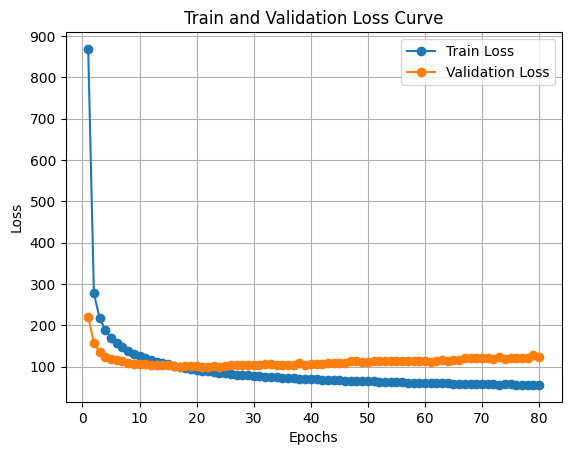

In [ ]:
train_loss_array = np.load(f"/content/drive/MyDrive/P3DCV/losses/train/difffmap_1.76573.npy")
val_loss_array = np.load(f"/content/drive/MyDrive/P3DCV/losses/val/difffmap_1.76573.npy")
epochs = np.arange(1, len(train_loss_array) + 1)

plt.plot(epochs, train_loss_array, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_array, label='Validation Loss', marker='o')

plt.title('Train and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#test loops
for epoch in range(n_epoch):
    train_losses = []
    eval_losses = []
    faust_losses = []
    metrics = []
    # Training single Epoch
    for i, data in enumerate(train_loader):
        vertsA, vertsB = data
        batch = vertsA.shape[0]
        vertsA = vertsA.to(device).to(torch.float32)
        vertsB = vertsB.to(device).to(torch.float32)
        cat_verts = torch.cat([vertsA.transpose(1,2), vertsB.transpose(1,2)], dim=0)
        optim.zero_grad()
        basisNet = basisNet.train()

        # Obtaining predicted basis
        cat_preds, _, _ = basisNet(cat_verts)#cat_pred.shape (B, n_points, k)

        basisA = cat_preds[:batch, :, :]
        basisB = cat_preds[batch:, :, :]
        # Computing optimal transformation
        pseudo_inv_A = torch.pinverse(basisA)
        C_opt = torch.matmul(pseudo_inv_A, basisB)
        opt_A = torch.matmul(basisA, C_opt)

        # SoftMap
        dist_matrix = torch.cdist(opt_A, basisB)
        s_max = torch.nn.Softmax(dim=1)
        s_max_matrix = s_max(-dist_matrix)

        # Basis Loss
        eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))

        #metric = torch.mean(torch.square(s_max_matrix - torch.identity(s_max_matrix.shape[0]))) # measuring how well we are approximating the ground-truth correspondence
        # Back Prop
        eucl_loss.backward()
        optim.step()
        train_losses.append(eucl_loss.detach().item())
        #metrics.append(metric.detach().item())
    ave_train_loss = sum(train_losses) / len(train_losses)
    #ave_metric = sum(metrics) / len(metrics)
    print(f"training loss for epoch{epoch}:", ave_train_loss)
    #print(f"training metric for epoch{epoch}:", ave_metric)
    torch.save(basisNet.state_dict(), f"/content/drive/MyDrive/P3DCV/models/difffmap_resampled_epoch_{epoch}.pt")



In [ ]:
'''

    # Validation
    with torch.no_grad():
        eval_loss = 0
        for data in tqdm(dataset_test, 0):
            points = data[0]
            points = points.transpose(2, 1)
            points = points.cuda()
            basisNet = basisNet.eval()
            pred, _, _ = basisNet(points)
            basis_A = pred[1:,:,:]; basis_B = pred[:-1,:,:]
            pc_A = points[1:,:,:]; pc_B = points[:-1,:,:]

            pseudo_inv_A = torch.pinverse(basis_A)
            C_opt = torch.matmul(pseudo_inv_A, basis_B)
            opt_A = torch.matmul(basis_A, C_opt)

            dist_matrix = torch.cdist(opt_A, basis_B)
            s_max = torch.nn.Softmax(dim=1)
            s_max_matrix = s_max(-dist_matrix)
            eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, torch.transpose(pc_B,1,2)) - torch.transpose(pc_B,1,2)))
            eval_loss +=   eucl_loss.item()

        print('EPOCH ' + str(epoch) + ' - eva_loss: ' + str(eval_loss))

        # Saving if best model so far
        if eval_loss <  best_eval_loss:
            print('save model')
            best_eval_loss = eval_loss
            torch.save(basisNet.state_dict(), '%s/basis_model_best.pth' % (outf))

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)

        # Logging losses
        np.save(outf+'/train_losses_basis.npy',train_losses)
        np.save(outf+'/eval_losses_basis.npy',eval_losses)
'''